### Part 1: Generate Synthetic Networks (1 point)
Generate the following synthetic networks using the networkx package or another preferred library:
- Random networks (Erdos–Rényi) with:
  - n = 1000
  - Average degree (k) = 1 and 4
- Scale-free networks (Barabási–Albert) with:
  - n = 1000
  - m = 2 and 4

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import os

In [2]:
n = 1000
k_avg_list = [1, 4]
p_avg_list = [k / (n-1) for k in k_avg_list]
m_list = [2, 4]
er_graphs = [nx.erdos_renyi_graph(n, p) for p in p_avg_list]
ba_graphs = [nx.barabasi_albert_graph(n, m) for m in m_list]

### Part 2: Plot Degree Distributions (2 points)
Plot the degree distributions of the synthetic networks created in Part 1, as well as the degree distributions for networks provided in the datasets.

In [5]:
gml_files = [f for f in os.listdir("datasets/") if f.endswith(".gml")]

real_nws = [nx.read_gml(os.path.join("datasets/", path)) for path in gml_files]

In [6]:
graph_dict = {
    "ER_k=1": er_graphs[0],
    "ER_k=4": er_graphs[1],
    "BA_m=2": ba_graphs[0],
    "BA_m=4": ba_graphs[1],
    "Network_airlines": real_nws[0],
    "Network_power": real_nws[1]
}

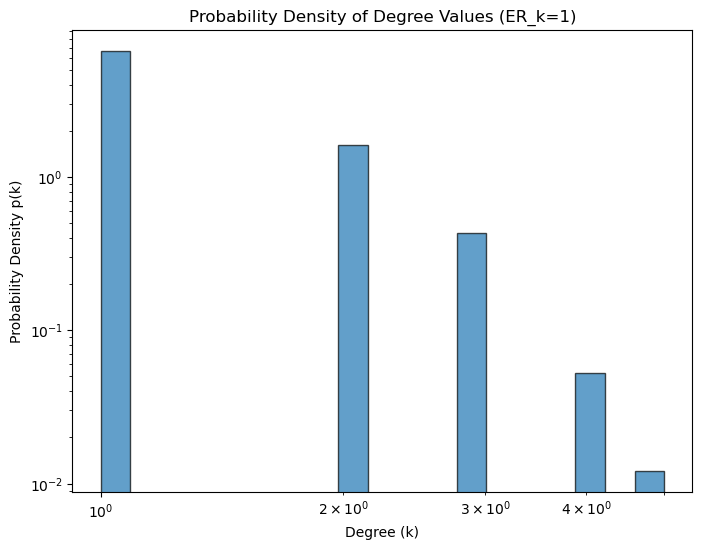

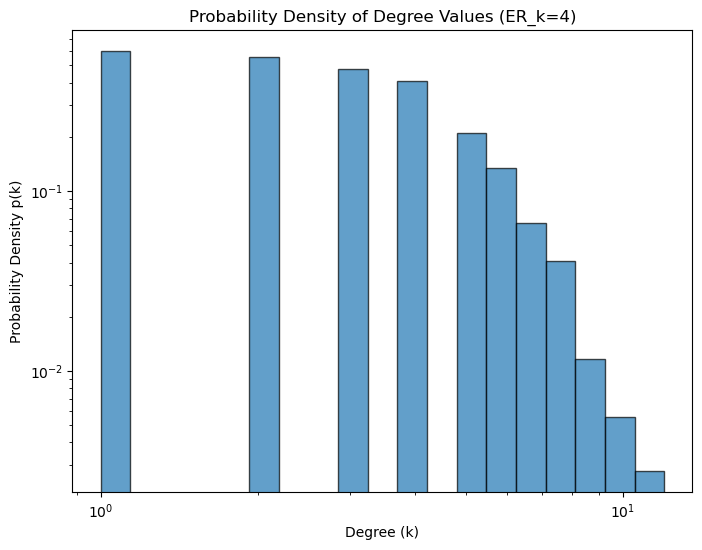

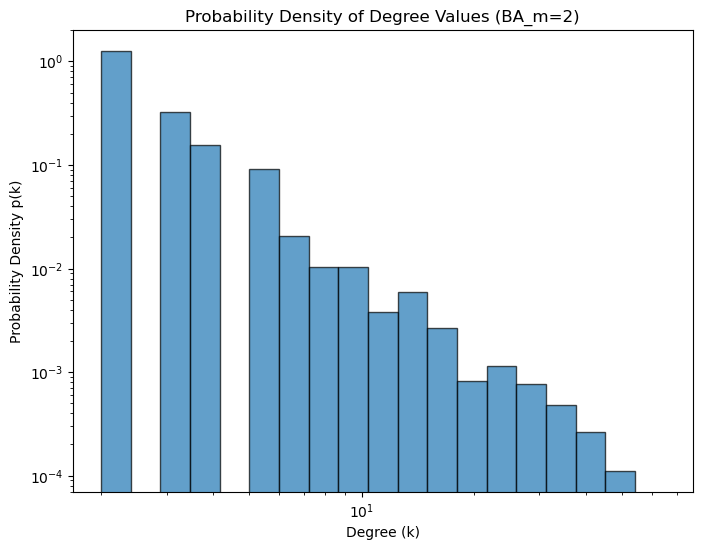

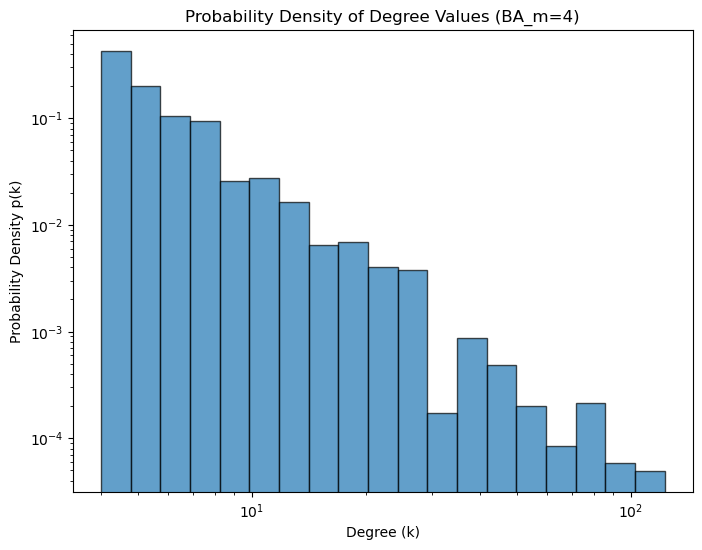

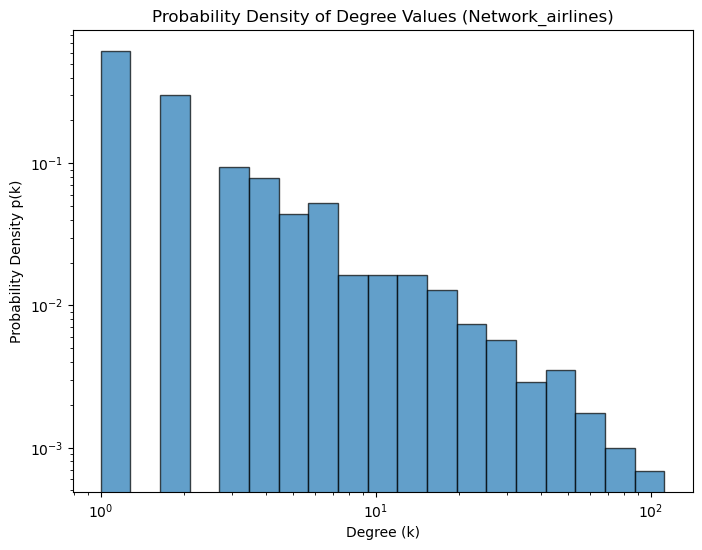

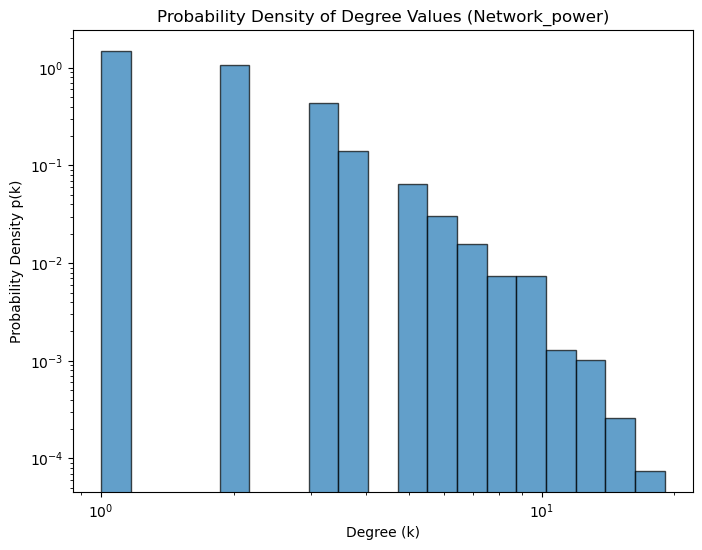

In [7]:
def plot_degree_distribution(g_dict):
    for label, graph in g_dict.items():
        degrees = [degree for node, degree in graph.degree()]
        degrees = [d for d in degrees if d > 0]

        min_degree = min(degrees)
        max_degree = max(degrees)

        bins = np.logspace(np.log10(min_degree), np.log10(max_degree), num=20)

        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=bins, density=True, edgecolor="black", alpha=0.7)

        plt.xscale("log")
        plt.yscale("log")

        plt.xlabel("Degree (k)")
        plt.ylabel("Probability Density p(k)")
        plt.title(f"Probability Density of Degree Values ({label})")
        plt.show()


plot_degree_distribution(graph_dict)

### Part 3: Largest Connected Component Size (2 points)
For both the synthetic graphs and the real networks, plot the size of the largest connected component as a function of removed edges and nodes in the following scenarios:
1. Random attacks (failures)
2. Targeted attacks (using degree centrality and betweenness centrality)

### Part 4: Comments (1 point)
Provide commentary on the plots above, reflecting on the discussed concepts from the class sessions.
